# Start


In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
    MaxPooling2D,
    Rescaling,
)
from keras.models import Sequential

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Testing


## Definitions


In [3]:
BATCH_SIZE = 64
EPOCHS = 25


def get_dataset(size, color_mode):
    # Load dataset
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        f"../data/processed/faces/{color_mode}/{size}x{size}",
        shuffle=True,
        image_size=(size, size),
        batch_size=BATCH_SIZE,
    )

    # Split dataset
    data_size = len(ds)
    train_split = 0.7
    val_split = 0.2
    test_split = 0.1

    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    # Cache, shuffle and prefetch
    buffer_size = len(train_ds) * BATCH_SIZE
    buffer_size

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    input_shape = [BATCH_SIZE, size, size, 1] if color_mode == "grayscale" else [BATCH_SIZE, size, size, 3]

    return train_ds, val_ds, test_ds, input_shape


def get_input_shape(train_ds):
    for batch, _ in train_ds.take(1):
        return batch.shape

In [4]:
def show_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


def show_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


def show_evaluation(model, val_ds, history):
    loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
    print(f"Loss: {round(loss, 3)}, Acc: {round(acc*100, 3)}%")
    show_accuracy(history)
    show_loss(history)

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

## Main Model


In [6]:
train_ds, val_ds, test_ds, input_shape = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 18652 files belonging to 3 classes.


In [7]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Second conv block
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Third conv block
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [8]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

Epoch 1/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 266ms/step - accuracy: 0.4690 - loss: 1.4074 - val_accuracy: 0.1131 - val_loss: 1.2573
Epoch 2/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.6012 - loss: 0.9178 - val_accuracy: 0.6026 - val_loss: 0.8796
Epoch 3/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.6412 - loss: 0.8243 - val_accuracy: 0.6024 - val_loss: 0.8755
Epoch 4/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - accuracy: 0.6722 - loss: 0.7558 - val_accuracy: 0.7093 - val_loss: 0.7050
Epoch 5/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.6742 - loss: 0.7499 - val_accuracy: 0.6684 - val_loss: 0.7307
Epoch 6/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.6816 - loss: 0.7198 - val_accuracy: 0.7406 - val_loss: 0.6217
Epoch 7/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - accuracy: 0.6988 - loss: 0.6991 - val_accuracy: 0.7093 - val_loss: 0.6891
Epoch 8/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.7076 - loss: 0

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7405 - loss: 0.6208
Loss: 0.622, Acc: 74.057%


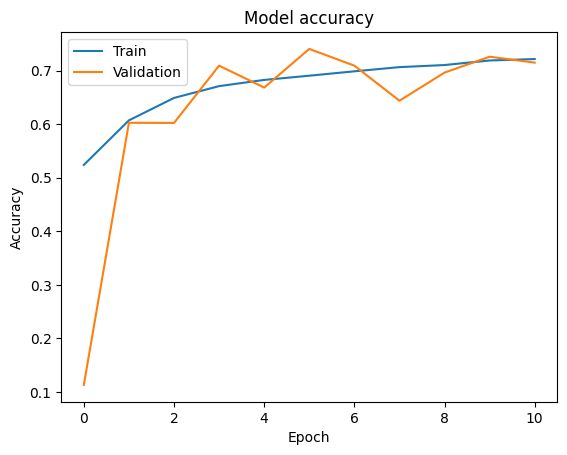

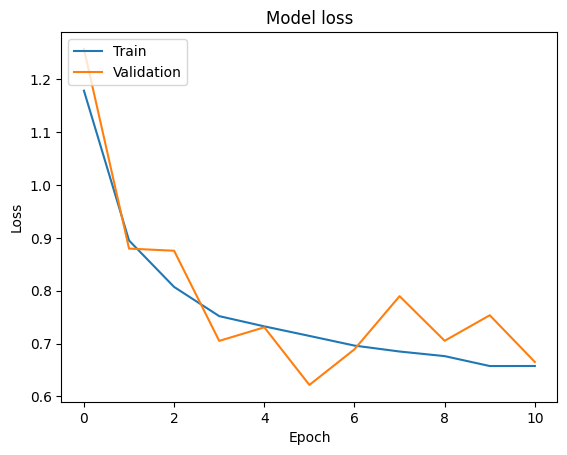

In [9]:
show_evaluation(model, val_ds, history)

## Testing Models


### Model 1


In [ ]:
train_ds, val_ds, test_ds, input_shape = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Second conv block
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Third conv block
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

In [ ]:
show_evaluation(model, val_ds, history)

### Model 2


In [ ]:
train_ds, val_ds, test_ds, input_shape = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Second conv block
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Third conv block
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

In [ ]:
show_evaluation(model, val_ds, history)